# Praca domowa nr 4 - operacje na tekstach
### Sebastian Deręgowski, Maciej Gryszkiewicz, Piotr Okonek

W tej części pracy domowej skleiliśmy wszystkie nasze artykuły w jeden (plik *articles.txt*) i analizowaliśmy go przy zastosowaniu technik NLP.

In [ ]:
import pandas as pd

import warnings
warnings.filterwarnings('ignore')

## Wstępna obróbka

Wczytujemy tekst i zamieniamy go na małe litery:

In [ ]:
articles = open("articles.txt", "r", encoding="utf-8")
articles = articles.read().lower()

Przy użyciu wyrażeń regularnych wyrzucamy wszystko, co nie jest słowami. Osobny regex ustawiamy dla słów połączonych myślnikiem, a także na słowo *covid-19*, którego jest całkiem sporo. Poza tym wyrzucamy wszystkie stopwordy, czyli słowa typu *and*, *the*, *in*, ponieważ jest ich zdecydowanie najwięcej, a wnoszą one niewielką wartość do tekstu.

In [ ]:
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

tokens = word_tokenize(articles)
tokens_clear = []
tokens_clear_clear = []

letters = re.compile("^[a-z]+$")
words_h= re.compile("[a-z]+-[a-z]+")
words_h_d = re.compile("[a-z]+-[0-9]+")

nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

for token in tokens:
    if letters.match(token) or words_h.match(token) or words_h_d.match(token):
        tokens_clear.append(token)
        if token not in stop_words:
            tokens_clear_clear.append(token)

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\01143557\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Poniżej prezentują się liczności odpowiednio: bez przekształceń, po zastosowaniu wyrażeń regularnych oraz po wyrzuceniu stopwordów:

In [ ]:
print(len(tokens))
print(len(tokens_clear))
print(len(tokens_clear_clear))


51690
39123
25544


## Lematyzacja i stemming

Następnie dokonaliśmy procesu lematyzacji, który znacząco zmniejszył liczbę unikalnych słów w zbiorze:

In [ ]:
from nltk.stem import WordNetLemmatizer
nltk.download('wordnet')

tokens_clear_clear_clear = []

lemmatizer = WordNetLemmatizer()
for token in tokens_clear_clear:
    tokens_clear_clear_clear.append(lemmatizer.lemmatize(token))

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\01143557\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [ ]:
print(len(set(tokens_clear_clear)))
print(len(set(tokens_clear_clear_clear)))

4539
4166


Dokonaliśmy również stemmingu, który także zmniejszył liczebność zbioru:

In [ ]:
from nltk.stem import PorterStemmer
porter = PorterStemmer()

tokens_clear_clear_clear_clear = []

for token in tokens_clear_clear_clear:
    tokens_clear_clear_clear_clear.append(porter.stem(token))

In [ ]:
print(len(set(tokens_clear_clear_clear_clear)))

3330


## Porównanie wordcloudów

Postanowiliśmy porównać chmurę słów dla naszych połączonych artykułów przed i po naszych operacjach.

In [ ]:
frequencies_old = {}
for token in tokens_clear:
    if token in frequencies_old:
        frequencies_old[token] += 1
    else:
        frequencies_old[token] = 1

frequencies = {}
for token in tokens_clear_clear_clear_clear:
    if token in frequencies:
        frequencies[token] += 1
    else:
        frequencies[token] = 1

Przed preprocessingiem:

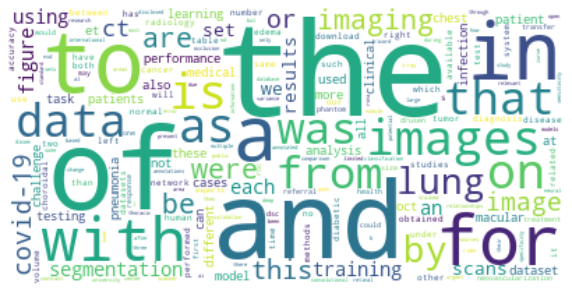

In [ ]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud
wordcloud = WordCloud(background_color="white")
wordcloud.generate_from_frequencies(frequencies=frequencies_old)
plt.figure(figsize = (10,8))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

Po preprocessingu:

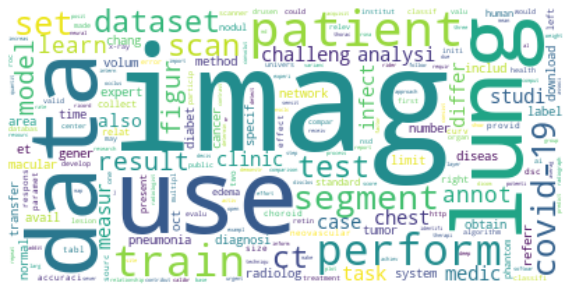

In [ ]:
wordcloud = WordCloud(background_color="white")
wordcloud.generate_from_frequencies(frequencies=frequencies)
plt.figure(figsize = (10,8))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

Widzimy, że pierwotnie dominowały stop wordy, teraz z kolei widzimy dużo słownictwa medycznego i datowego.

## Part of speech tagging

Podzielliśmy także zbiór (sprzed lematyzacji i stemmingu, aby zachować oryginalne słowa) pod kądem części mowy słów.

In [ ]:
pos = nltk.pos_tag(tokens_clear_clear)

frequencies_pos = {}
for p in pos:
    if p[1] in frequencies_pos:
        frequencies_pos[p[1]] += 1
    else: frequencies_pos[p[1]] = 1

<Figure size 1440x576 with 0 Axes>

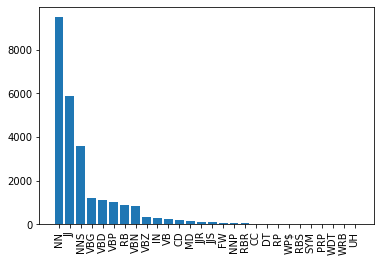

<Figure size 1440x576 with 0 Axes>

In [ ]:
tmp = pd.DataFrame({"Part of speech": frequencies_pos.keys(), "Count" :frequencies_pos.values()})
tmp = tmp.sort_values("Count", ascending=False)
plt.bar(x=tmp["Part of speech"], height=tmp["Count"])
plt.xticks(rotation=90)
plt.figure(figsize=(20,8))


Widzimy, że najwięcej jest rzeczowników, dalej w kolejności są przymiotniki. Wynika to przede wszystkim z usunięcia stopwordów, inaczej one zdominowałyby zbiór.

Zbadaliśmy także długość słów przed i po preprocessingu:

In [ ]:
word_lengths = []
for token in tokens_clear:
    word_lengths.append(len(token))

word_lengths_clear = []
for token in tokens_clear_clear_clear_clear:
    word_lengths_clear.append(len(token))


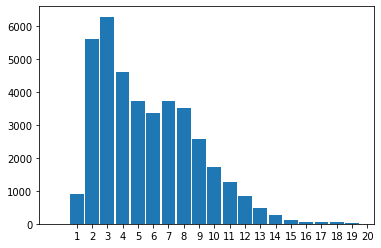

In [ ]:
plt.hist(word_lengths, range=(0,20), bins=20, rwidth=0.9, align="left");
plt.xticks([i for i in range(1, 21)]);

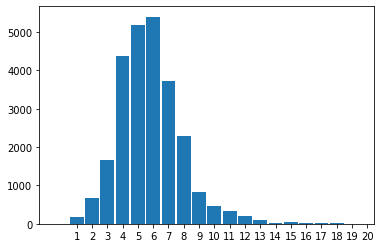

In [ ]:
plt.hist(word_lengths_clear, range=(0,20), bins=20, rwidth=0.9, align="left");
plt.xticks([i for i in range(1, 21)]);

Dość nieoczekiwanie po zastosowaniu preprocessingu "unormowaliśmy" średnią liczbę słów w wyrazach.

## Wektoryzacja

Do wektoryzacji użyliśmy word2veca, głównie dlatego, że już z nim pracowaliśmy.

In [ ]:
from gensim.models import Word2Vec, KeyedVectors
word2vec = KeyedVectors.load_word2vec_format("GoogleNews-vectors-negative300.bin.gz", binary=True)
word2vec['be']

array([-2.28515625e-01, -8.83789062e-02,  1.27929688e-01,  1.50390625e-01,
       -7.32421875e-02,  8.64257812e-02,  6.39648438e-02,  9.66796875e-02,
        5.83496094e-02,  1.43554688e-01, -2.92968750e-02, -1.86523438e-01,
        1.19628906e-02,  4.95605469e-02,  7.32421875e-02,  1.26953125e-01,
        4.32128906e-02,  1.24023438e-01, -3.36914062e-02,  5.37109375e-03,
        2.23388672e-02, -6.05468750e-02,  1.94335938e-01, -3.81469727e-03,
        1.33789062e-01, -4.05883789e-03, -2.05078125e-01, -5.78613281e-02,
        1.29882812e-01,  1.73339844e-02, -9.61914062e-02, -1.31835938e-02,
       -2.10937500e-01,  1.55273438e-01,  2.89062500e-01, -7.27539062e-02,
        5.37109375e-02, -2.31933594e-02,  9.61914062e-02,  4.79125977e-03,
        2.42187500e-01,  1.41601562e-01,  8.05664062e-02, -6.78710938e-02,
       -4.61425781e-02, -9.13085938e-02,  5.63964844e-02,  1.89453125e-01,
        1.53350830e-03,  9.17968750e-02,  1.08886719e-01,  1.31835938e-01,
        8.20312500e-02, -

Powyżej widzimy output dla przykładowego słowa *be*, jest to 300-elementowy wektor.

In [ ]:
vectorized = []
for token in tokens_clear_clear:
    try:
        vectorized.append(word2vec[token])
    except KeyError:
        continue

Nasza wyjściowa ramka danych wygląda następująco:

In [ ]:
df = pd.DataFrame(np.row_stack(vectorized))
df

,0,1,2,3,4,5,6,7,8,9,...,290,291,292,293,294,295,296,297,298,299
0,0.257812,-0.251953,0.044189,0.285156,-0.140625,0.092773,0.462891,-0.145508,0.001099,0.216797,...,-0.421875,-0.171875,-0.029175,0.195312,-0.068359,0.328125,0.197266,-0.019653,0.154297,-0.242188
1,0.107422,0.012695,0.328125,0.024414,-0.075684,0.052979,0.110840,0.168945,0.021240,-0.073242,...,-0.265625,-0.009216,-0.131836,-0.018433,-0.154297,-0.059814,-0.077148,-0.017456,-0.145508,-0.172852
2,0.004211,-0.353516,0.003555,-0.207031,-0.063477,0.170898,0.185547,0.178711,0.273438,0.104980,...,0.015869,0.177734,-0.005188,0.146484,-0.099609,0.308594,-0.302734,-0.044189,-0.164062,-0.112793
3,0.007019,-0.162109,-0.198242,-0.093262,-0.172852,-0.026855,-0.011902,-0.150391,-0.031494,-0.127930,...,0.037598,0.380859,-0.230469,-0.365234,0.010681,-0.097656,0.007172,0.158203,0.223633,-0.230469
4,-0.079590,0.235352,0.142578,-0.155273,-0.248047,0.115723,0.113770,0.056396,0.279297,-0.095703,...,0.116211,-0.155273,-0.088867,-0.200195,-0.097168,0.132812,-0.026123,0.151367,0.173828,0.196289
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23563,-0.279297,0.034180,-0.051514,0.277344,0.056152,0.156250,0.059082,0.157227,-0.017822,-0.121094,...,0.113281,-0.012451,0.146484,0.353516,-0.047119,-0.076172,-0.093262,-0.006348,-0.185547,0.271484
23564,0.112793,-0.229492,0.017822,0.192383,-0.225586,0.009338,-0.017090,-0.172852,0.195312,-0.054443,...,0.433594,0.255859,-0.200195,0.277344,0.046387,-0.320312,-0.024536,-0.261719,-0.136719,-0.081543
23565,-0.279297,0.034180,-0.051514,0.277344,0.056152,0.156250,0.059082,0.157227,-0.017822,-0.121094,...,0.113281,-0.012451,0.146484,0.353516,-0.047119,-0.076172,-0.093262,-0.006348,-0.185547,0.271484
23566,0.112793,-0.229492,0.017822,0.192383,-0.225586,0.009338,-0.017090,-0.172852,0.195312,-0.054443,...,0.433594,0.255859,-0.200195,0.277344,0.046387,-0.320312,-0.024536,-0.261719,-0.136719,-0.081543
